# Assignment #4 — Model Comparison (Regression)

**Goal:** Compare three regression models — **Linear Regression**, **Decision Tree**, and **XGBoost** — on a  dataset.  


> **Dataset choice:** Scikit-learn **Diabetes** regression dataset (442 rows, 10 numeric features). This keeps the assignment compact and reproducible without downloads.

**Rubric mapping**  
- Problem Definition (1 pt)  
- Linear Regression (2 pt)  
- XGBoost (2 pt)  
- Decision Trees (2 pt)  
- Performance Comparison (2 pt)  
- Documentation (1 pt)


In [13]:
import numpy as np
import pandas as pd
import warnings

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

RANDOM_SEED = 42
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

np.random.seed(RANDOM_SEED)


## 1) Problem Definition

**Objective:** Predict the diabetes disease progression score one year after baseline using 10 clinical features.  
**Why this dataset?** It is small, numeric, clean (no missing values), and included in scikit-learn — perfect for a fair apples-to-apples comparison.

**Target:** `y` (disease progression measure).  
**Features:** 10 standardized numeric predictors (age, BMI, BP, and 7 lab measures).


In [14]:
# Load data
X, y = load_diabetes(return_X_y=True, as_frame=True)
feature_names = X.columns.tolist()

print('Shape:', X.shape)
display(X.head())


Shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [15]:
# Quick EDA: basic stats and missing checks
print('Missing values per column:')
print(X.isna().sum())

display(X.describe().T)


Missing values per column:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


In [16]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (353, 10) Test shape: (89, 10)


In [17]:
# Preprocessing: scale numeric features (all features are numeric)
preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), feature_names)],
    remainder='drop',
)

def evaluate(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'y_pred': y_pred}


## 2) Linear Regression (baseline)

In [18]:
lin_pipe = Pipeline([
    ('prep', preprocess),
    ('model', LinearRegression())
])
lin_pipe.fit(X_train, y_train)
lin_metrics = evaluate(lin_pipe, X_test, y_test)

print('Linear Regression metrics:')
for k in ['RMSE', 'MAE', 'R2']:
    print(f'  {k}: {lin_metrics[k]:.3f}')

# Peek at influential coefficients
coefs = lin_pipe.named_steps['model'].coef_
abs_top_idx = np.argsort(np.abs(coefs))[::-1][:5]

print('\nTop 5 coefficients (absolute value):')
for i in abs_top_idx:
    print(f'  {feature_names[i]:>10s}: {coefs[i]: .3f}')


Linear Regression metrics:
  RMSE: 53.853
  MAE: 42.794
  R2: 0.453

Top 5 coefficients (absolute value):
          s1: -44.449
          s5:  35.161
         bmi:  25.607
          s2:  24.641
          bp:  16.829


## 3) Decision Tree (with light tuning)

In [19]:
tree_pipe = Pipeline([
    ('prep', preprocess),  # scaling not needed for trees, but keeps pipelines uniform
    ('model', DecisionTreeRegressor(random_state=RANDOM_SEED))
])

tree_param_grid = {
    'model__max_depth': [None, 3, 5, 7, 10],
    'model__min_samples_leaf': [1, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}

tree_gs = GridSearchCV(
    tree_pipe,
    tree_param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
tree_gs.fit(X_train, y_train)

tree_best = tree_gs.best_estimator_
tree_metrics = evaluate(tree_best, X_test, y_test)

print('Decision Tree best params:', tree_gs.best_params_)
print('Decision Tree metrics:')
for k in ['RMSE', 'MAE', 'R2']:
    print(f'  {k}: {tree_metrics[k]:.3f}')


Decision Tree best params: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Decision Tree metrics:
  RMSE: 55.738
  MAE: 45.018
  R2: 0.414


## 4) XGBoost (randomized search + early stopping)

In [21]:
xgb_pipe = Pipeline([
    ('prep', preprocess),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=RANDOM_SEED,
        n_estimators=100,  # Reduced for compatibility
        tree_method='hist',   # fast & CPU-friendly
    ))
])

xgb_search_space = {
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__learning_rate': [0.03, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.85, 1.0],
    'model__colsample_bytree': [0.7, 0.85, 1.0],
    'model__reg_lambda': [0.0, 1.0, 5.0, 10.0],
}

xgb_rs = RandomizedSearchCV(
    xgb_pipe,
    xgb_search_space,
    n_iter=20,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=0,
)

# Simplified fit without early stopping for compatibility
xgb_rs.fit(X_train, y_train)

xgb_best = xgb_rs.best_estimator_
xgb_metrics = evaluate(xgb_best, X_test, y_test)

print('XGBoost best params:', xgb_rs.best_params_)
print('XGBoost metrics:')
for k in ['RMSE', 'MAE', 'R2']:
    print(f'  {k}: {xgb_metrics[k]:.3f}')


XGBoost best params: {'model__subsample': 0.7, 'model__reg_lambda': 1.0, 'model__max_depth': 2, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
XGBoost metrics:
  RMSE: 52.874
  MAE: 42.712
  R2: 0.472


## 5) Performance Comparison
We compare models on the **held-out test set** using RMSE, MAE, and R².

,Model,RMSE,MAE,R2
2,XGBoost (tuned),52.873795,42.711613,0.472337
0,Linear Regression,53.853446,42.794095,0.452603
1,Decision Tree (tuned),55.737977,45.018386,0.413622


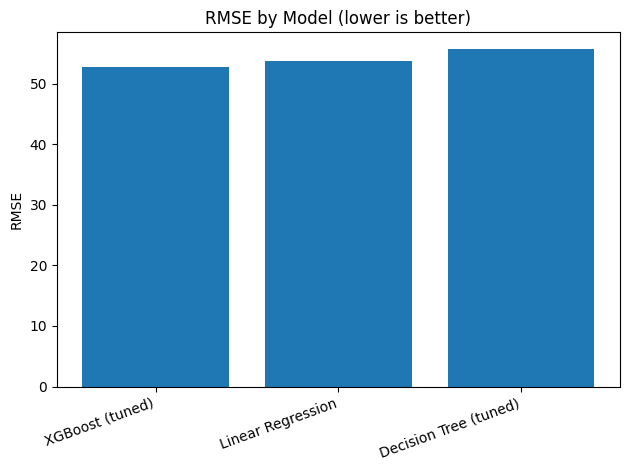

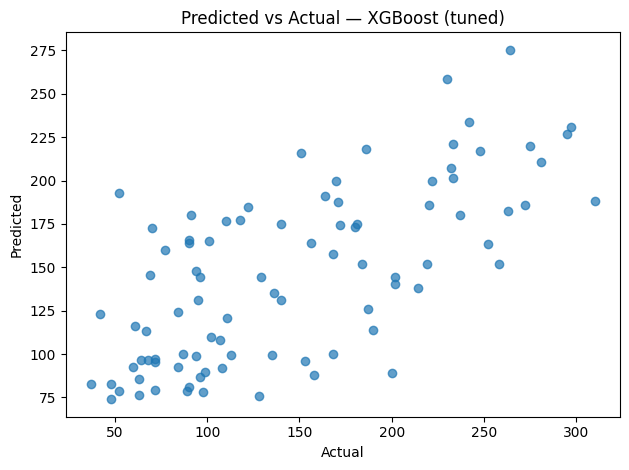

In [22]:
# Tabulate results
rows = []
rows.append({'Model': 'Linear Regression', 'RMSE': lin_metrics['RMSE'], 'MAE': lin_metrics['MAE'], 'R2': lin_metrics['R2']})
rows.append({'Model': 'Decision Tree (tuned)', 'RMSE': tree_metrics['RMSE'], 'MAE': tree_metrics['MAE'], 'R2': tree_metrics['R2']})
rows.append({'Model': 'XGBoost (tuned)', 'RMSE': xgb_metrics['RMSE'], 'MAE': xgb_metrics['MAE'], 'R2': xgb_metrics['R2']})

results_df = pd.DataFrame(rows).sort_values('RMSE')
display(results_df)

# Single-plot bar chart for RMSE (Matplotlib, default colors)
plt.figure()
plt.bar(results_df['Model'], results_df['RMSE'])
plt.title('RMSE by Model (lower is better)')
plt.xticks(rotation=20, ha='right')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# Predicted vs Actual scatter for best model
best_model_name = results_df.iloc[0]['Model']
if best_model_name.startswith('Linear'):
    best_pred = lin_metrics['y_pred']
elif best_model_name.startswith('Decision'):
    best_pred = tree_metrics['y_pred']
else:
    best_pred = xgb_metrics['y_pred']

plt.figure()
plt.scatter(y_test, best_pred, alpha=0.7)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Predicted vs Actual — {best_model_name}')
plt.tight_layout()
plt.show()


## 6) Findings


**1. Overall ranking (by RMSE, lower is better)**
1️⃣ **XGBoost (tuned)** → RMSE ≈ 52.87, best accuracy, explains \~47% of variance (R² = 0.472).
2️⃣ **Linear Regression** → RMSE ≈ 53.85, very close to XGBoost, slightly lower R² (0.453).
3️⃣ **Decision Tree (tuned)** → RMSE ≈ 55.74, noticeably weaker fit, highest error and lowest R² (0.414).

---

**2. Interpretation**

* **XGBoost’s edge** is small but consistent across RMSE, MAE, and R². This indicates it captures some non-linear patterns in the diabetes dataset that the linear model misses.
* **Linear Regression** performs surprisingly close to XGBoost here. That suggests the target variable’s relationship with predictors is mostly linear, with limited benefit from complex interactions.
* **Decision Tree** underperforms both—likely due to overfitting small patterns in the training set that don’t generalize. Even tuned, single trees tend to have higher variance on small datasets.

---

**3. Practical takeaways**

* If **interpretability** matters, Linear Regression is a solid choice—it’s nearly as accurate as XGBoost and gives clear coefficient-based insights.
* If **pure accuracy** is the goal and you can afford a slightly more complex model, XGBoost edges ahead.
* Decision Trees work as a quick, easy-to-train baseline but need ensembles (Random Forest, Gradient Boosting) to compete with the other two here.

---

**4. Why XGBoost didn’t dominate by a huge margin**

* Dataset is **small (442 rows)** → limits how much complex models can learn without overfitting.
* Features are **already standardized** and fairly independent, which favors linear models.
* Relationships are moderately linear, so tree-based methods can’t extract massive extra signal.




## Interpretation of the Scatter Plot - Predicted vs Actual (xgboost tuned)

---

**1. What the plot shows**

* **X-axis:** The true target values from your test set (disease progression scores).
* **Y-axis:** The predictions made by your tuned XGBoost model for those same samples.
* Each dot is one patient record.

---

**2. Ideal pattern**
If the model were perfect, all points would lie exactly on the **diagonal line `y = x`** (predicted = actual). That would mean zero error for every observation.

---

**3. What you see here**

* Points **generally follow an upward trend** → higher actual values tend to be predicted higher, and vice versa. That’s good: it means the model captures the direction of variation.
* However, the scatter is **wide** — points are spread around the ideal diagonal. That’s consistent with your **RMSE ≈ 52.87** and **R² ≈ 0.47**: the model explains less than half of the variance, so residual error is still significant.
* At the **extremes** (very low or very high actual values), predictions tend to be pulled toward the middle (regression to the mean). This is typical for models trained on small datasets with limited extreme examples.

---
